**Imports and Installations**

In [6]:
%%capture
!pip install git+https://github.com/MSF-Collaborate/msf-toolbox.git@features/acled_addition
!pip install prophet

In [7]:
from msftoolbox.acled.extract import ACLEDExtractor
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
import folium

**Initialization**

In [ ]:
acled_extractor = ACLEDExtractor(
    api_key="ESkuYk0zNSuhPHhP5gH4",
    email="tpham.27@berkeley.edu",
    limit = 100000,
    format="csv"
)

In [ ]:
events_list = acled_extractor.list_events(
    event_date="2023-01-01|2025-01-01",
    event_date_where="BETWEEN",
    fatalities="0",
    fatalities_where=">"
)

In [ ]:
events = pd.DataFrame(events_list)

**EDA**

In [ ]:
len(events)

100000

In [ ]:
# Preprocessing

events['event_date'] = pd.to_datetime(events['event_date'])
fix_event_date = events['event_date']

for col in events.columns:
    try:
        events[col] = pd.to_numeric(events[col], errors='raise')
    except ValueError:
        pass

events['event_date'] = fix_event_date

In [ ]:
with pd.option_context('display.max_columns', None):
    print(events.head())

  event_id_cnty event_date  year  time_precision       disorder_type  \
0      BFO12795 2024-11-08  2024               1  Political violence   
1      DRC33933 2024-11-08  2024               1  Political violence   
2      ETH14053 2024-11-08  2024               2  Political violence   
3      ETH14055 2024-11-08  2024               2  Political violence   
4      ETH14056 2024-11-08  2024               2  Political violence   

                   event_type sub_event_type  \
0  Violence against civilians         Attack   
1                     Battles    Armed clash   
2                     Battles    Armed clash   
3                     Battles    Armed clash   
4                     Battles    Armed clash   

                                              actor1 assoc_actor_1  \
0       JNIM: Group for Support of Islam and Muslims                 
1  Military Forces of the Democratic Republic of ...                 
2                Military Forces of Ethiopia (2018-)                

In [ ]:
# Shows the columns that have empty rows, and the # of empty rows for that column
for col in events.columns:
  empty_sum = sum(events[col]=='')
  if empty_sum > 0:
    print(col + ": " + str(empty_sum))

assoc_actor_1: 83698
actor2: 225
assoc_actor_2: 74193
inter2: 224
civilian_targeting: 51242
admin1: 12
admin2: 1522
admin3: 48316
tags: 93946


In [ ]:
events = events[events['admin1'] != '']

In [ ]:
map = folium.Map(location=[events['latitude'].mean(), events['longitude'].mean()], zoom_start=5)
for _, row in events.iloc[:999, :].iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color='red',
                        fill=True).add_to(map)
map.save('conflict_map.html')

In [ ]:
map

**Time Series Analysis**

In [ ]:
events['week_start'] = events['event_date'] - pd.to_timedelta(events['event_date'].dt.weekday, unit='D')
events['week_start'] = events['event_date']

# Aggregate events by admin1 and location, count the number of events (or fatalities)
events_agg = events.groupby(['admin1', 'week_start'])['fatalities'].sum().reset_index(name='fatality_sum')
events_agg.head()

,admin1,week_start,fatality_sum
0,Abia,2023-01-17,3
1,Abia,2023-01-25,1
2,Abia,2023-02-17,7
3,Abia,2023-02-25,2
4,Abia,2023-03-25,1


In [ ]:
admin1_agg = events_agg.groupby('admin1').filter(lambda sf: len(sf)>0).groupby('admin1').size()
admin1_agg

,0
admin1,
Abia,43
Abidjan,3
Abim,2
Abyan,105
Abyei,42
...,...
Zinder,1
Zombo,3
Zou,5


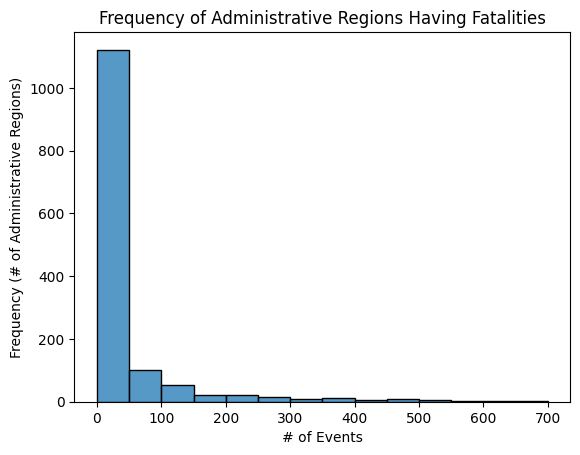

In [ ]:
bins = np.arange(0, max(admin1_agg) + 50, 50)

sns.histplot(admin1_agg, bins=bins)

plt.title("Frequency of Administrative Regions Having Fatalities")
plt.xlabel("# of Events")
plt.ylabel("Frequency (# of Administrative Regions)")

plt.show()

In [ ]:
events_agg = events_agg.groupby('admin1').filter(lambda sf: len(sf)>50)

In [ ]:
from prophet import Prophet

region_values = events_agg['admin1'].unique()

forecast_results = []

for admin1 in region_values:
    loc_data = events_agg[events_agg['admin1'] == admin1][['week_start', 'fatality_sum']]
    loc_data = loc_data.rename(columns={'week_start': 'ds', 'fatality_sum': 'y'})  # Prophet format

    loc_data = loc_data.dropna(subset=['ds', 'y'])


    model = Prophet(yearly_seasonality=True)
    model.fit(loc_data)

    future = model.make_future_dataframe(periods=60)

    forecast = model.predict(future)

    forecast['admin1'] = admin1

    forecast_results.append(forecast)

all_forecasts = pd.concat(forecast_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzf3pyhv7/gdp3zcbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzf3pyhv7/8hsqli4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4640', 'data', 'file=/tmp/tmpzf3pyhv7/gdp3zcbq.json', 'init=/tmp/tmpzf3pyhv7/8hsqli4c.json', 'output', 'file=/tmp/tmpzf3pyhv7/prophet_modelj9bnrc_m/prophet_model-20241117203435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzf3

In [ ]:
all_forecasts.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,admin1
0,2023-01-10,2.710701,0.414142,5.464705,2.710701,2.710701,0.212297,0.212297,0.212297,-0.313341,-0.313341,-0.313341,0.525638,0.525638,0.525638,0.0,0.0,0.0,2.922998,Abyan
1,2023-01-18,2.726941,1.485834,6.862449,2.726941,2.726941,1.362597,1.362597,1.362597,0.758186,0.758186,0.758186,0.604411,0.604411,0.604411,0.0,0.0,0.0,4.089538,Abyan
2,2023-01-23,2.737091,1.142809,6.435255,2.737091,2.737091,1.087100,1.087100,1.087100,0.368425,0.368425,0.368425,0.718674,0.718674,0.718674,0.0,0.0,0.0,3.824190,Abyan
3,2023-02-03,2.759420,-0.005610,5.525943,2.759420,2.759420,-0.040822,-0.040822,-0.040822,0.104583,0.104583,0.104583,-0.145406,-0.145406,-0.145406,0.0,0.0,0.0,2.718598,Abyan
4,2023-02-07,2.767540,-0.704030,4.203284,2.767540,2.767540,-0.949847,-0.949847,-0.949847,-0.313341,-0.313341,-0.313341,-0.636507,-0.636507,-0.636507,0.0,0.0,0.0,1.817693,Abyan


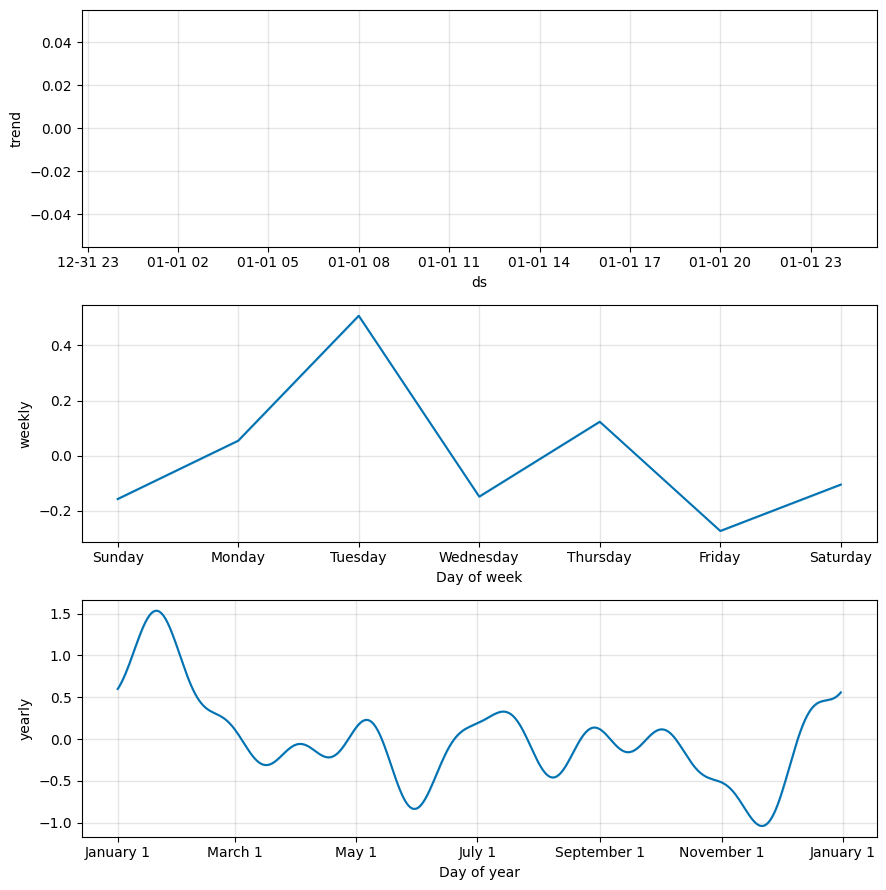

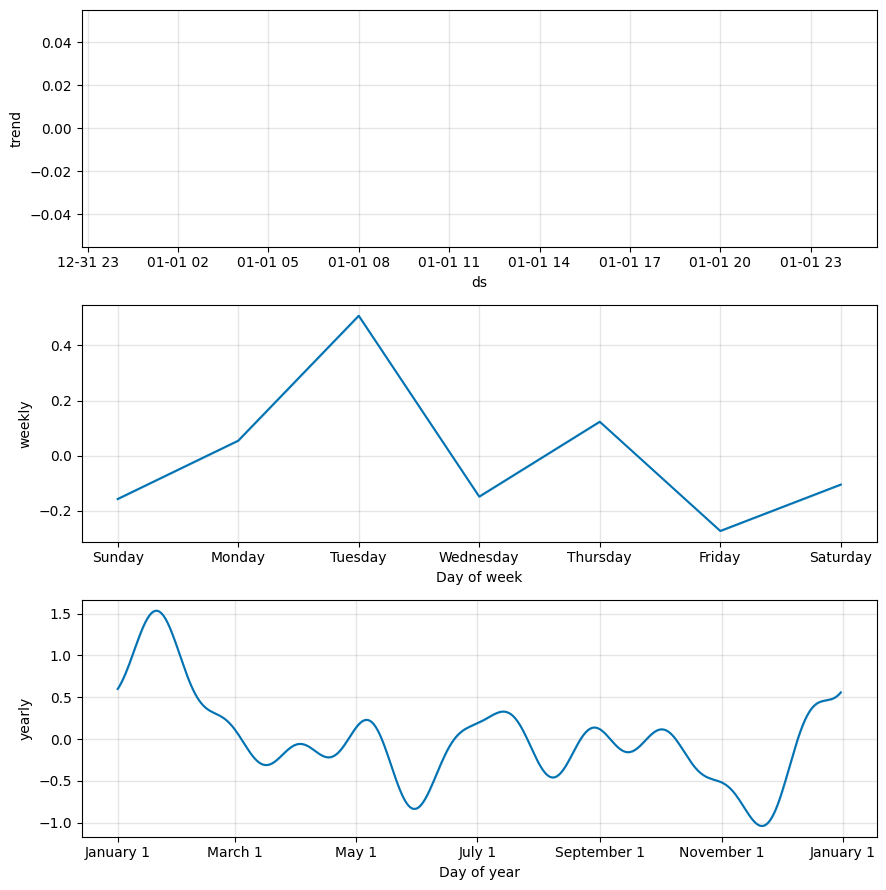

In [ ]:
i = 3
selected_admin1 = all_forecasts['admin1'].unique()[i]

filtered_data = all_forecasts[all_forecasts['admin1']=='selected_admin1']
model.plot_components(filtered_data)

In [ ]:
def classify_risk(row, lower_quantile, upper_quantile):
    if row['yhat'] < lower_quantile:
        return 'Low Risk'
    elif row['yhat'] < upper_quantile:
        return 'Medium Risk'
    elif row['yhat'] >= upper_quantile:
        return 'High Risk'
    else:
        return 'Extreme Risk'

lower_quantile = all_forecasts['yhat_lower'].quantile(0.25)
upper_quantile = all_forecasts['yhat_upper'].quantile(0.75)

all_forecasts['predicted_risk_level'] = all_forecasts.apply(classify_risk, axis=1,
                                                           lower_quantile=lower_quantile,
                                                           upper_quantile=upper_quantile)

print(all_forecasts[['ds', 'admin1', 'yhat', 'predicted_risk_level']].head())


          ds admin1      yhat predicted_risk_level
0 2023-01-10  Abyan  2.922998          Medium Risk
1 2023-01-18  Abyan  4.089538          Medium Risk
2 2023-01-23  Abyan  3.824190          Medium Risk
3 2023-02-03  Abyan  2.718598          Medium Risk
4 2023-02-07  Abyan  1.817693          Medium Risk


In [ ]:
all_forecasts[all_forecasts['predicted_risk_level']=='Low Risk']['admin1'].value_counts()

,count
admin1,
Taraba,55
Lakes,42
Menaka,40
West Darfur,37
West,35
Khartoum,34
Al Jazirah,33
Galgaduud,32
Zaporizhia,32


<Axes: xlabel='yhat', ylabel='Count'>

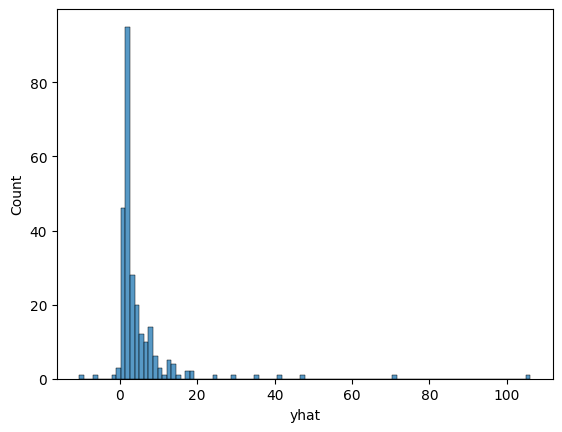

In [ ]:
all_forecasts=all_forecasts[all_forecasts['admin1'] != "Taraba"]
sns.histplot(all_forecasts.groupby('admin1')['yhat'].mean())

In [ ]:

def compute_trend(group):
    X = (group['ds'] - group['ds'].min()).dt.days.values.reshape(-1, 1)  # Convert dates to days since min date
    y = group['yhat'].values

    model = LinearRegression()
    model.fit(X, y)

    return model.coef_[0]

trend_summary = (
    all_forecasts.groupby('admin1')
    .apply(lambda group: pd.Series({
        'yhat_mean': group['yhat'].mean(),
        'yhat_trend': compute_trend(group),
    }))
    .reset_index()
)

clustering_features = trend_summary[['yhat_mean', 'yhat_trend']]

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=2024)  # 3 risk levels: low, medium, high
trend_summary['risk_cluster'] = kmeans.fit_predict(clustering_features)

cluster_map = {
    0: 'Low Risk',
    1: 'Medium Risk',
    2: 'High Risk',
}
trend_summary['admin1_risk_level'] = trend_summary['risk_cluster'].map(cluster_map)

events_with_risk = events.merge(
    trend_summary[['admin1', 'admin1_risk_level']], on='admin1', how='left'
)

events_with_risk.head()


<ipython-input-34-c7727b11a238>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,week_start,admin1_risk_level
0,BFO12795,2024-11-08,2024,1,Political violence,Violence against civilians,Attack,JNIM: Group for Support of Islam and Muslims,,Rebel group,...,-0.3566,1,Facebook,New media,"On 8 November 2024, JNIM militants attacked th...",2,,1731368104,2024-11-08,Low Risk
1,DRC33933,2024-11-08,2024,1,Political violence,Battles,Armed clash,Military Forces of the Democratic Republic of ...,,State forces,...,29.3460,1,Mediacongo.net,National,"On 8 November 2024, FARDC clashed with M23 in ...",1,,1731368107,2024-11-08,Low Risk
2,ETH14053,2024-11-08,2024,2,Political violence,Battles,Armed clash,Military Forces of Ethiopia (2018-),,State forces,...,36.8862,1,Wazema Radio,New media,"Around 8 November 2024 (as reported), ENDF cla...",1,,1731368107,2024-11-08,High Risk
3,ETH14055,2024-11-08,2024,2,Political violence,Battles,Armed clash,Military Forces of Ethiopia (2018-),,State forces,...,39.2395,1,Wazema Radio,New media,"Around 8 November 2024 (as reported), ENDF cla...",1,,1731368107,2024-11-08,High Risk
4,ETH14056,2024-11-08,2024,2,Political violence,Battles,Armed clash,Military Forces of Ethiopia (2018-),,State forces,...,37.2667,1,Wazema Radio,New media,"Around 8 November 2024 (as reported), ENDF cla...",1,,1731368107,2024-11-08,High Risk


In [ ]:
test=all_forecasts[all_forecasts['admin1']=='Taraba'].groupby('admin1').agg(
        yhat_mean=('yhat', 'mean'),
        yhat_trend=('yhat', lambda x: (x.iloc[-1] - x.iloc[0]) / len(x)),  # Rate of increase
        yhat_spread=('yhat_upper', lambda y: y.mean() - all_forecasts.loc[y.index, 'yhat_lower'].mean())  # Spread
    ).reset_index()
test

,admin1,yhat_mean,yhat_trend,yhat_spread
0,Taraba,-163.919391,0.098261,-155.083066


In [ ]:
events_with_risk['admin1_risk_level'] = events_with_risk['admin1_risk_level'].fillna('No Risk')
events_with_risk.groupby('admin1').first()['admin1_risk_level'].value_counts()

,count
admin1_risk_level,
No Risk,1123
Low Risk,251
High Risk,9
Medium Risk,2


In [ ]:
import folium
from folium.plugins import MarkerCluster

latitude_mean = events_with_risk['latitude'].mean()
longitude_mean = events_with_risk['longitude'].mean()

m = folium.Map(location=[latitude_mean, longitude_mean], zoom_start=6)

marker_cluster = MarkerCluster().add_to(m)

cluster_colors = {
    'No Risk': 'green',
    'Low Risk': 'blue',
    'Medium Risk': 'orange',
    'High Risk': 'red',
}

for _, row in events_with_risk.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Admin1: {row['admin1']}<br>Risk Level: {row['admin1_risk_level']}",
        icon=folium.Icon(color=cluster_colors[row['admin1_risk_level']])
    ).add_to(marker_cluster)

m.save("risk_clusters_map.html")
m


Buffered data was truncated after reaching the output size limit.

In [ ]:
from folium.plugins import HeatMap

heatmap_data = events_with_risk[['latitude', 'longitude', 'admin1_risk_level']]

risk_level_mapping = {
    'No Risk': 1,
    'Low Risk': 2,
    'Medium Risk': 3,
    'High Risk': 4
}
heatmap_data['risk_numeric'] = heatmap_data['admin1_risk_level'].map(risk_level_mapping)

heatmap_points = heatmap_data[['latitude', 'longitude', 'risk_numeric']].values.tolist()

m = folium.Map(location=[heatmap_data['latitude'].mean(), heatmap_data['longitude'].mean()], zoom_start=6)

HeatMap(heatmap_points, radius=10, blur=15, max_zoom=1).add_to(m)

m.save("heatmap.html")

from IPython.display import IFrame
m

<ipython-input-58-3c57c2dec5ea>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['risk_numeric'] = heatmap_data['admin1_risk_level'].map(risk_level_mapping)


In [ ]:
import IPython

IPython.display.HTML(filename='/content/real_time_conflict_map (2).html')

In [8]:
acled_extractor = ACLEDExtractor(
    api_key="88KWzjVrWU-1f-7Nguud",
    email="kc716@berkeley.edu",
    limit = 100000,
    format="csv"
)

In [9]:
import folium
from folium.plugins import HeatMap

events_list = acled_extractor.list_events(
    event_date="2022-01-01|2024-01-01",
    event_date_where="BETWEEN",
    fatalities="0",
    fatalities_where=">"
)
events = pd.DataFrame(events_list)
events.to_csv('events_data_full.csv', index=False)
events_df = pd.read_csv('events_data_full.csv')
events_df['event_date'] = pd.to_datetime(events_df['event_date'])
events_df = events_df[['event_date', 'latitude', 'longitude', 'event_type', 'fatalities', 'country', 'region']]

map_real_time = folium.Map(location=[events_df['latitude'].mean(), events_df['longitude'].mean()], zoom_start=3)

for _, row in events_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['fatalities'] == 0 else 'red',
        popup=f"Event Type: {row['event_type']}, Date: {row['event_date'].date()}, Fatalities: {row['fatalities']}",
        fill=True,
        fill_opacity=0.6
    ).add_to(map_real_time)

map_real_time.save('real_time_conflict_map.html')

STEPs to run the interactive map:

1. Go to the notebook Files and tract "real_time_conflict_map.html"

2. Download the html file and open on local device.

3. Run the the html file!